In [1]:
# Import libraries needed for the neural network and data handling
import torch
# Q: What is PyTorch, and why is it useful for building neural networks?
# A: PyTorch is a Python library for machine learning, especially deep learning. It’s useful because it provides tools for building neural networks, handling tensors (like arrays), and performing computations on GPUs for faster training.
import torch.nn as nn
# Q: What kind of tools does the nn module provide?
# A: The nn module provides building blocks like layers (e.g., Conv2d, Linear), activation functions (e.g., Tanh), and loss functions (e.g., CrossEntropyLoss) to construct and train neural networks.
from torch.utils.data import DataLoader
# Q: Why do we need a DataLoader for training?
# A: DataLoader batches the dataset, shuffles it, and loads data efficiently, allowing the model to process small groups of images at a time, which saves memory and speeds up training.
import torchvision
# Q: What does torchvision provide for working with image datasets?
# A: Torchvision provides datasets (e.g., MNIST), pre-trained models, and image transformation tools (e.g., ToTensor, Normalize) for computer vision tasks.
from torchvision import transforms
# Q: Why do we need to transform images before training?
# A: Transformations prepare images (e.g., converting to tensors, normalizing) to match the model’s input requirements and improve training stability.
import matplotlib.pyplot as plt
# Q: How will we use matplotlib in this script?
# A: Matplotlib will plot training and test accuracy/loss curves to visualize how the model’s performance improves over epochs.

In [2]:
# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Q: Why check for CUDA availability?
# A: CUDA enables GPU acceleration, which speeds up neural network computations. We check to use GPU if available, otherwise fall back to CPU.

In [3]:
device

device(type='cuda')

In [4]:
# Define image transformations for MNIST (28x28 to 32x32 and normalization)
transform = transforms.Compose([
# Q: Why combine multiple transformations into one?
# A: Combining transformations ensures they’re applied in sequence (e.g., padding, then tensor conversion, then normalization) efficiently to each image.
    transforms.Pad(2),
# Q: Why pad the image from 28x28 to 32x32?
# A: LeNet-5 expects 32x32 inputs. Padding adds 2 pixels on each side of 28x28 MNIST images to match this size.
    transforms.ToTensor(),
# Q: What does ToTensor do to the image data?
# A: ToTensor converts images to PyTorch tensors (arrays) and scales pixel values from [0, 255] to [0, 1] for model processing.
    transforms.Normalize((0.1307,), (0.3081,))
# Q: Why use these specific values for normalization?
# A: These values (mean=0.1307, std=0.3081) are MNIST’s dataset mean and standard deviation, used to standardize pixel values for faster, more stable training.
])

In [5]:
# Load the MNIST training dataset
train_dataset = torchvision.datasets.MNIST(
# Q: What type of data is in the MNIST dataset?
# A: MNIST contains 60,000 grayscale images (28x28) of handwritten digits (0–9) with corresponding labels.
    root="./data",
# Q: Where will the dataset be stored on your computer?
# A: The dataset is saved in the "./data" directory on your local machine.
    train=True,
# Q: Why set train=True for this dataset?
# A: train=True loads the 60,000 training images for model training, not the test set.
    download=True,
# Q: What happens if the dataset isn’t already downloaded?
# A: If not downloaded, torchvision downloads MNIST to the root directory; if already present, it uses the local copy.
    transform=transform
# Q: Why apply the transformation here?
# A: Transformations are applied to each image as it’s loaded to prepare it for the model (e.g., padding, normalization).
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


In [6]:
# Load the MNIST test dataset
test_dataset = torchvision.datasets.MNIST(
# Q: Why do we need a separate test dataset?
# A: The test dataset (10,000 images) evaluates the model’s performance on unseen data to check for generalization.
    root="./data",
# Q: Why use the same root directory as the training dataset?
# A: Using the same root avoids redundant downloads and keeps all MNIST data in one place.
    train=False,
# Q: What does train=False mean?
# A: train=False loads the 10,000 test images instead of the training set.
    download=True,
# Q: Why is download=True useful?
# A: It ensures the test dataset is downloaded if not already present, making the code portable.
    transform=transform
# Q: Why apply the same transformation to the test dataset?
# A: The same transformations ensure test images have the same format (size, normalization) as training images for consistent evaluation.
)

In [7]:
# Create a DataLoader for the training dataset
train_loader = DataLoader(
# Q: What does a DataLoader do with the dataset?
# A: DataLoader batches the dataset, shuffles it, and provides an iterator for efficient data loading during training.
    train_dataset,
# Q: Why pass the train_dataset here?
# A: train_dataset specifies the data to be batched and shuffled for training.
    batch_size=128,
# Q: Why process the data in batches of 128?
# A: Batch size of 128 balances memory usage and training speed, allowing the model to learn from multiple images at once.
    shuffle=True
# Q: Why shuffle the training data?
# A: Shuffling randomizes the order of images each epoch, preventing the model from learning patterns based on data order.
)

In [8]:
# Create a DataLoader for the test dataset
test_loader = DataLoader(
# Q: Why do we need a DataLoader for testing?
# A: DataLoader for testing batches the test data for efficient evaluation, processing multiple images at once.
    test_dataset,
# Q: Why use the test_dataset here?
# A: test_dataset provides the data for evaluating the model’s performance on unseen images.
    batch_size=128,
# Q: Why use the same batch size as training?
# A: Same batch size ensures consistency in processing, though it’s less critical for testing since gradients aren’t computed.
    shuffle=False
# Q: Why not shuffle the test data?
# A: Shuffling test data is unnecessary since we’re only evaluating, and consistent order can help with debugging or comparisons.
)

In [9]:
# Define the LeNet-5 model using nn.Sequential
model = nn.Sequential(
# Q: What does nn.Sequential do to organize layers?
# A: nn.Sequential chains layers in order, passing the output of one layer as input to the next, simplifying model definition.
    nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=0),
# Q: Why start with 1 input channel?
# A: MNIST images are grayscale (1 channel), so the first Conv2d takes 1 input channel and outputs 6 feature maps.
    nn.Tanh(),
# Q: What does the Tanh activation function do?
# A: Tanh introduces nonlinearity, mapping values to [-1, 1], helping the model learn complex patterns.
    nn.AvgPool2d(kernel_size=2, stride=2),
# Q: How does average pooling reduce image size?
# A: AvgPool2d averages pixel values in 2x2 regions, reducing height/width by half (e.g., 28x28 to 14x14), saving computation.
    nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
# Q: Why increase to 16 channels?
# A: Increasing to 16 channels allows the model to learn more complex features from the 6 input feature maps.
    nn.Tanh(),
# Q: Why apply Tanh again after convolution?
# A: Tanh adds nonlinearity after convolution, enabling the model to capture more intricate patterns.
    nn.AvgPool2d(kernel_size=2, stride=2),
# Q: What is the output size after this pooling?
# A: Pooling reduces 10x10 (after Conv2d) to 5x5, as kernel=2, stride=2 halves the dimensions.
    nn.Conv2d(16, 120, kernel_size=5, stride=1, padding=0),
# Q: Why 120 channels in this layer?
# A: 120 channels create a rich feature representation, preparing for the fully connected layers.
    nn.Tanh(),
# Q: Why use Tanh after the final convolution?
# A: Tanh adds nonlinearity to the final convolutional features, aiding in complex pattern recognition.
    nn.Flatten(),
# Q: What does Flatten do to the tensor?
# A: Flatten converts the 3D tensor (120x1x1) to a 1D vector (120) for input to fully connected layers.
    nn.Linear(120, 84),
# Q: How is the input size 120 calculated?
# A: After flattening, the tensor has 120 channels (from Conv2d) and 1x1 spatial size, so 120 * 1 * 1 = 120.
    nn.Tanh(),
# Q: Why use Tanh in the fully connected layer?
# A: Tanh adds nonlinearity to the dense layer, helping the model learn complex relationships.
    nn.Linear(84, 10)
# Q: Why does the final layer output 10 values?
# A: The final layer outputs 10 values, one for each MNIST digit (0–9), representing class scores.
).to(device)
# Q: Why move the model to the device (CPU/GPU)?
# A: Moving to device ensures the model’s computations (and weights) use GPU if available, for faster processing.


In [10]:
# Define the loss function
criterion = nn.CrossEntropyLoss()
# Q: Why use CrossEntropyLoss for classification?
# A: CrossEntropyLoss combines log softmax and negative log likelihood, ideal for multi-class classification like MNIST (10 classes).

In [11]:
# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Q: What does the Adam optimizer do?
# A: Adam adjusts model weights using gradients, balancing speed and stability with adaptive learning rates.

In [12]:
# Set the number of epochs
epochs = 5
# Q: Why train for multiple epochs?
# A: Multiple epochs allow the model to see the dataset multiple times, improving learning and accuracy.

In [13]:
# Initialize lists to store training history
train_losses = []
# Q: Why track training loss?
# A: Tracking training loss shows how well the model is fitting the training data over time.
train_accuracies = []
# Q: Why measure accuracy during training?
# A: Accuracy measures the percentage of correct predictions, indicating how well the model learns.
test_losses = []
# Q: Why evaluate loss on the test set?
# A: Test loss shows how well the model generalizes to unseen data, detecting overfitting.
test_accuracies = []
# Q: Why check accuracy on the test set?
# A: Test accuracy measures the model’s performance on unseen data, ensuring it generalizes well.

In [14]:
# Training loop
for epoch in range(epochs):
# Q: Why loop over epochs?
# A: Looping over epochs lets the model learn from the entire dataset multiple times, refining weights.
    model.train()
# Q: What does model.train() do?
# A: model.train() sets the model to training mode, enabling layers like Dropout (if used) and gradient updates.
    running_loss = 0.0
# Q: Why track loss within an epoch?
# A: Running loss accumulates batch losses to compute the average loss for the epoch.
    correct = 0
# Q: Why count correct predictions?
# A: Counting correct predictions helps calculate training accuracy for the epoch.
    total = 0
# Q: Why track the total number of samples?
# A: Total tracks the number of samples processed to compute average loss and accuracy.
    for images, labels in train_loader:
# Q: What does the DataLoader provide in each iteration?
# A: DataLoader provides batches of images (tensors) and their corresponding labels.
        images = images.to(device)
# Q: Why move images to the device?
# A: Images are moved to GPU/CPU to match the model’s device for computation.
        labels = labels.to(device)
# Q: Why move labels to the device?
# A: Labels are moved to the same device as the model to compute the loss.
        optimizer.zero_grad()
# Q: Why reset gradients before each step?
# A: Zeroing gradients prevents accumulation from previous batches, ensuring correct updates.
        outputs = model(images)
# Q: What does the model output for each batch?
# A: The model outputs a tensor of shape (batch_size, 10), with scores for each digit class.
        loss = criterion(outputs, labels)
# Q: How is the loss calculated?
# A: CrossEntropyLoss compares output scores to true labels, computing the prediction error.
        loss.backward()
# Q: What does backward() do to the loss?
# A: backward() computes gradients of the loss with respect to model parameters.
        optimizer.step()
# Q: How does the optimizer update the model?
# A: The optimizer adjusts model weights using gradients to minimize the loss.
        running_loss += loss.item() * images.size(0)
# Q: Why multiply by batch size?
# A: Multiplying by batch size weights the loss by the number of samples, for accurate averaging.
        _, predicted = torch.max(outputs, 1)
# Q: How do we get predictions from outputs?
# A: torch.max(outputs, 1) finds the index (class) with the highest score for each image.
        total += labels.size(0)
# Q: Why add the batch size to total?
# A: Adding batch size updates the total number of samples processed in the epoch.
        correct += (predicted == labels).sum().item()
# Q: How do we count correct predictions?
# A: Comparing predicted and true labels, we count matches and sum them for the epoch.
    epoch_loss = running_loss / len(train_dataset)
# Q: Why divide by dataset size?
# A: Dividing by dataset size gives the average loss per sample for the epoch.
    epoch_acc = correct / len(train_dataset)
# Q: Why calculate accuracy this way?
# A: Dividing correct predictions by total samples gives the fraction of correct predictions (accuracy).
    train_losses.append(epoch_loss)
# Q: Why store the epoch loss?
# A: Storing epoch loss tracks training progress for analysis and plotting.
    train_accuracies.append(epoch_acc)
# Q: Why store the epoch accuracy?
# A: Storing accuracy helps visualize how the model’s performance improves over epochs.

    # Evaluate on test set
    model.eval()
# Q: What does model.eval() do?
# A: model.eval() sets the model to evaluation mode, disabling training-specific behaviors like Dropout.
    test_loss = 0.0
# Q: Why track test loss separately?
# A: Test loss is tracked to evaluate the model’s performance on unseen data.
    test_correct = 0
# Q: Why count correct predictions for testing?
# A: Counting correct test predictions helps compute test accuracy.
    test_total = 0
# Q: Why track total test samples?
# A: Total test samples are tracked to calculate average test loss and accuracy.
    with torch.no_grad():
# Q: Why disable gradient computation during testing?
# A: Disabling gradients saves memory and speeds up evaluation, as we don’t update weights.
        for images, labels in test_loader:
# Q: Why iterate over the test_loader?
# A: test_loader provides batches of test images and labels for evaluation.
            images = images.to(device)
# Q: Why move test images to the device?
# A: Test images are moved to the model’s device for consistent computation.
            labels = labels.to(device)
# Q: Why move test labels to the device?
# A: Test labels are moved to compute the loss on the same device as the model.
            outputs = model(images)
# Q: What does the model output for test images?
# A: The model outputs class scores for each test image, shape (batch_size, 10).
            loss = criterion(outputs, labels)
# Q: Why calculate loss for test data?
# A: Test loss measures how well the model predicts on unseen data.
            test_loss += loss.item() * images.size(0)
# Q: Why accumulate test loss?
# A: Accumulating weighted loss allows computing the average test loss for the epoch.
            _, predicted = torch.max(outputs, 1)
# Q: How do we get test predictions?
# A: torch.max finds the predicted class (highest score) for each test image.
            test_total += labels.size(0)
# Q: Why update total test samples?
# A: Total test samples are updated to compute average loss and accuracy.
            test_correct += (predicted == labels).sum().item()
# Q: Why count correct test predictions?
# A: Counting correct predictions helps compute test accuracy.
    test_loss = test_loss / len(test_dataset)
# Q: Why average the test loss?
# A: Averaging gives the per-sample test loss, making it comparable across datasets.
    test_acc = test_correct / len(test_dataset)
# Q: Why calculate test accuracy?
# A: Test accuracy shows the model’s performance on unseen data, indicating generalization.
    test_losses.append(test_loss)
# Q: Why store test loss?
# A: Storing test loss tracks evaluation performance for analysis and plotting.
    test_accuracies.append(test_acc)
# Q: Why store test accuracy?
# A: Storing test accuracy helps visualize generalization performance over epochs.

    # Print results for this epoch
    print(f"Epoch {epoch+1}: Train Loss {epoch_loss:.4f}, Train Acc {epoch_acc:.4f}, Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
# Q: Why print results each epoch?
# A: Printing results monitors training progress, helping identify issues like overfitting or slow learning.

Epoch 1: Train Loss 0.3214, Train Acc 0.9121, Test Loss 0.1007, Test Acc 0.9691
Epoch 2: Train Loss 0.0790, Train Acc 0.9762, Test Loss 0.0557, Test Acc 0.9817
Epoch 3: Train Loss 0.0527, Train Acc 0.9836, Test Loss 0.0444, Test Acc 0.9846
Epoch 4: Train Loss 0.0417, Train Acc 0.9872, Test Loss 0.0356, Test Acc 0.9878
Epoch 5: Train Loss 0.0317, Train Acc 0.9902, Test Loss 0.0435, Test Acc 0.9852


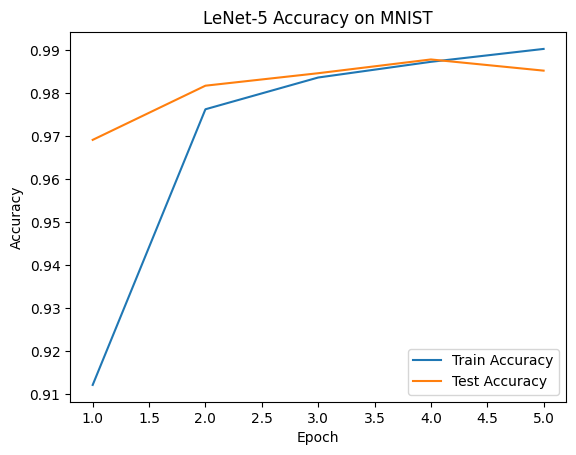

In [15]:
# Plot training and test accuracy
plt.figure()
# Q: Why create a new figure for plotting?
# A: A new figure ensures a clean canvas for the accuracy plot, avoiding overlap with other plots.
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
# Q: What does this line plot?
# A: This plots training accuracy for each epoch, showing how well the model learns the training data.
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy")
# Q: Why plot test accuracy?
# A: Plotting test accuracy shows how well the model generalizes to unseen data over epochs.
plt.xlabel("Epoch")
# Q: Why label the x-axis?
# A: Labeling the x-axis as “Epoch” indicates the training iteration number for clarity.
plt.ylabel("Accuracy")
# Q: Why label the y-axis?
# A: Labeling the y-axis as “Accuracy” shows the metric being plotted (fraction of correct predictions).
plt.title("LeNet-5 Accuracy on MNIST")
# Q: Why set a title for the plot?
# A: The title identifies the plot’s purpose, showing it’s for LeNet-5’s accuracy on MNIST.
plt.legend()
# Q: What does the legend show?
# A: The legend distinguishes between training and test accuracy lines for easy interpretation.
plt.savefig("accuracy.png")
# Q: Why save the plot to a file?
# A: Saving the plot allows you to keep a record or share the visualization later.
plt.show()
# Q: Why display the plot?
# A: Displayingќ

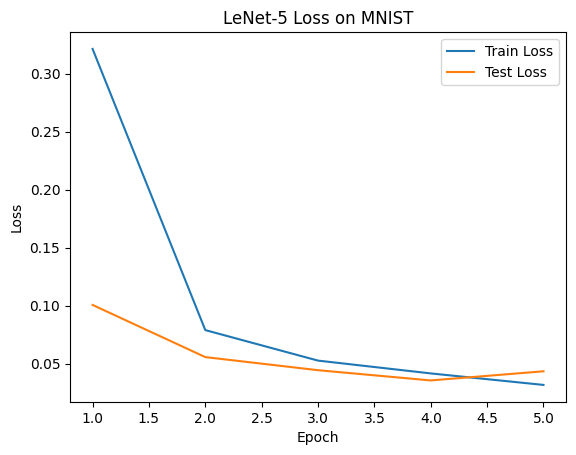

In [16]:
# Plot training and test loss
plt.figure()  # Q: Why create another figure?
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")  # Q: What does this line plot?
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")  # Q: Why plot test loss?
plt.xlabel("Epoch")  # Q: Why label the x-axis again?
plt.ylabel("Loss")  # Q: Why label the y-axis as Loss?
plt.title("LeNet-5 Loss on MNIST")  # Q: Why set a title for this plot?
plt.legend()  # Q: Why include a legend here?
plt.savefig("loss.png")  # Q: Why save this plot?
plt.show()  # Q: Why display this plot?

In [17]:
# Save the trained model
torch.save(model.state_dict(), "lenet5_weights.pth")  # Q: Why save the model weights?

# **AlexNet**

In [18]:
# Import Libraries
# Purpose: Load necessary Python libraries for building, training, and visualizing the neural network.
import torch
# Q: Why is PyTorch a good choice for building neural networks?
# A: PyTorch is a flexible machine learning library that supports dynamic computation graphs, tensor operations, and GPU acceleration, making it ideal for building and training neural networks efficiently.
import torch.nn as nn
# Q: What types of layers are provided by the nn module?
# A: The nn module provides layers like Conv2d, Linear, activation functions (e.g., ReLU), and loss functions (e.g., CrossEntropyLoss) to construct neural networks.
from torch.utils.data import DataLoader
# Q: Why do we need a DataLoader for our dataset?
# A: DataLoader batches the dataset, shuffles it, and loads data efficiently, allowing the model to process small groups of images at a time, saving memory and speeding up training.
import torchvision
# Q: What does torchvision offer for image datasets like MNIST?
# A: Torchvision provides datasets (e.g., MNIST), pre-trained models, and image transformation tools (e.g., ToTensor, Normalize) for computer vision tasks.
from torchvision import transforms
# Q: Why do we transform images before feeding them to the model?
# A: Transformations prepare images (e.g., resizing, normalizing) to match the model’s input requirements and improve training stability.
import matplotlib.pyplot as plt
# Q: How will matplotlib help us visualize training progress?
# A: Matplotlib will plot training and test accuracy/loss curves to visualize how the model’s performance evolves over epochs.

In [19]:
# Set Device
# Purpose: Configure the hardware (GPU or CPU) for computations to optimize performance.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Q: Why check for CUDA availability?
# A: CUDA enables GPU acceleration, which speeds up neural network computations. Checking ensures we use GPU if available, otherwise CPU.

In [20]:
# Define Image Transformations
# Purpose: Prepare MNIST images to match AlexNet’s input requirements and stabilize training.
transform = transforms.Compose([
# Q: Why combine multiple transformations?
# A: Combining transformations ensures they’re applied in sequence (e.g., padding, then tensor conversion, then normalization) efficiently to each image.
    transforms.Pad(2),
# Q: Why pad MNIST images from 28x28 to 32x32?
# A: AlexNet expects larger inputs; padding 28x28 MNIST images to 32x32 ensures compatibility with the model’s architecture.
    transforms.ToTensor(),
# Q: What does ToTensor do to the image data?
# A: ToTensor converts images to PyTorch tensors and scales pixel values from [0, 255] to [0, 1] for model processing.
    transforms.Normalize((0.1307,), (0.3081,))
# Q: Why use these specific values for normalization?
# A: These values (mean=0.1307, std=0.3081) are MNIST’s dataset mean and standard deviation, standardizing pixel values for faster, more stable training.
])

In [21]:
# Load Training Dataset
# Purpose: Load the MNIST training data for model training.
train_dataset = torchvision.datasets.MNIST(
# Q: What kind of data does MNIST contain?
# A: MNIST contains 60,000 grayscale images (28x28) of handwritten digits (0–9) with corresponding labels.
    root="./data",
# Q: Where will the dataset be saved locally?
# A: The dataset is saved in the "./data" directory on your local machine.
    train=True,
# Q: Why set train=True for the training dataset?
# A: train=True loads the 60,000 training images for model training, not the test set.
    download=True,
# Q: What happens if download=True?
# A: If not downloaded, torchvision downloads MNIST to the root directory; if already present, it uses the local copy.
    transform=transform
# Q: Why apply the transformation here?
# A: Transformations are applied to each image as it’s loaded to prepare it for the model (e.g., padding, normalization).
)

In [22]:
# Load Test Dataset
# Purpose: Load the MNIST test data for evaluating model performance on unseen data.
test_dataset = torchvision.datasets.MNIST(
# Q: Why do we need a separate test dataset?
# A: The test dataset (10,000 images) evaluates the model’s performance on unseen data to check generalization.
    root="./data",
# Q: Why use the same root directory as training?
# A: Using the same root avoids redundant downloads and keeps all MNIST data in one place.
    train=False,
# Q: What does train=False mean?
# A: train=False loads the 10,000 test images instead of the training set.
    download=True,
# Q: Why is download=True useful for testing?
# A: It ensures the test dataset is downloaded if not already present, making the code portable.
    transform=transform
# Q: Why use the same transformation for testing?
# A: The same transformations ensure test images have the same format (size, normalization) as training images for consistent evaluation.
)

In [23]:
# Create Training DataLoader
# Purpose: Batch and shuffle the training data for efficient processing during training.
train_loader = DataLoader(
# Q: What is the purpose of a DataLoader?
# A: DataLoader batches the dataset, shuffles it, and provides an iterator for efficient data loading during training.
    train_dataset,
# Q: Why pass the train_dataset here?
# A: train_dataset specifies the data to be batched and shuffled for training.
    batch_size=128,
# Q: Why use a batch size of 128?
# A: Batch size of 128 balances memory usage and training speed, allowing the model to learn from multiple images at once.
    shuffle=True
# Q: Why shuffle the training data?
# A: Shuffling randomizes the order of images each epoch, preventing the model from learning patterns based on data order.
)

In [24]:
# Create Test DataLoader
# Purpose: Batch the test data for efficient evaluation.
test_loader = DataLoader(  # Q: Why do we need a DataLoader for testing?
# A: DataLoader for testing batches the test data for efficient evaluation, processing multiple images at once.
    test_dataset,  # Q: Why use the test_dataset here?
# A: test_dataset provides the data for evaluating the model’s performance on unseen images.
    batch_size=128,  # Q: Why use the same batch size as training?
# A: Same batch size ensures consistency in processing, though it’s less critical for testing since gradients aren’t computed.
    shuffle=False  # Q: Why avoid shuffling test data?
# A: Shuffling test data is unnecessary since we’re only evaluating, and consistent order helps with debugging or comparisons.
)

In [25]:
# Define AlexNet Model
# Purpose: Create the AlexNet architecture adapted for MNIST, defining how input images are processed.
model = nn.Sequential(
# Q: Why use nn.Sequential to define the model?
# A: nn.Sequential chains layers in order, passing the output of one layer as input to the next, simplifying model definition.
    nn.Conv2d(1, 96, kernel_size=5, stride=1, padding=2),
# Q: Why 1 input channel for MNIST?
# A: MNIST images are grayscale (1 channel), so the first Conv2d takes 1 input channel and outputs 96 feature maps.
    nn.ReLU(),
# Q: Why use ReLU instead of Tanh (used in LeNet-5)?
# A: ReLU (max(0, x)) prevents vanishing gradients, is computationally faster, and promotes sparsity, unlike Tanh.
    nn.MaxPool2d(kernel_size=3, stride=2),
# Q: How does MaxPool2d differ from AvgPool2d?
# A: MaxPool2d takes the maximum value in each region, preserving strong features, while AvgPool2d averages values, smoothing features.
    nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
# Q: Why increase to 256 channels?
# A: Increasing to 256 channels allows the model to learn more complex features from the 96 input feature maps.
    nn.ReLU(),
# Q: Why apply ReLU after each convolution?
# A: ReLU adds nonlinearity after convolution, enabling the model to capture complex patterns.
    nn.MaxPool2d(kernel_size=3, stride=2),
# Q: How does this pooling affect the image size?
# A: MaxPool2d reduces spatial dimensions (e.g., 15x15 to 7x7), saving computation while retaining key features.
    nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
# Q: Why use a smaller kernel (3x3)?
# A: Smaller 3x3 kernels reduce parameters and computation while maintaining expressive power.
    nn.ReLU(),
# Q: Why is ReLU used again here?
# A: ReLU adds nonlinearity, helping the model learn intricate patterns in deeper layers.
    nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
# Q: Why same number of channels?
# A: Keeping 384 channels maintains feature richness while refining patterns with additional convolution.
    nn.ReLU(),
# Q: Why apply ReLU after this layer?
# A: ReLU ensures nonlinearity, allowing the model to learn complex feature combinations.
    nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
# Q: Why reduce to 256 channels?
# A: Reducing to 256 channels decreases computation before the final pooling and dense layers.
    nn.ReLU(),
# Q: Why use ReLU before pooling?
# A: ReLU adds nonlinearity before pooling, ensuring only meaningful features are passed forward.
    nn.MaxPool2d(kernel_size=3, stride=2),
# Q: What is the output size after this pooling?
# A: Pooling reduces 7x7 to 3x3 (256 channels), as kernel=3, stride=2 shrinks dimensions.
    nn.Flatten(),
# Q: Why flatten the output before fully connected layers?
# A: Flatten converts the 3D tensor (256x3x3) to a 1D vector (2304) for input to dense layers.
    nn.Linear(256 * 3 * 3, 4096),
# Q: Why use 256*3*3=2304 as the input size?
# A: The previous layer outputs 256 channels at 3x3, so 256 * 3 * 3 = 2304 is the flattened size.
    nn.ReLU(),
# Q: Why use ReLU in fully connected layers?
# A: ReLU adds nonlinearity in dense layers, helping learn complex relationships.
    nn.Dropout(p=0.5),
# Q: What does Dropout do during training?
# A: Dropout randomly disables 50% of neurons, preventing overfitting by reducing reliance on specific neurons.
    nn.Linear(4096, 4096),
# Q: Why use such a large fully connected layer?
# A: Large layers (4096 units) capture complex patterns, though adapted here for MNIST’s simpler task.
    nn.ReLU(),
# Q: Why apply ReLU again?
# A: ReLU adds nonlinearity, enhancing the model’s ability to learn from dense layer outputs.
    nn.Dropout(p=0.5),
# Q: Why use Dropout again?
# A: Additional Dropout further prevents overfitting in the large second dense layer.
    nn.Linear(4096, 10)
# Q: Why output 10 values in the final layer?
# A: The final layer outputs 10 values, one for each MNIST digit (0–9), representing class scores.
).to(device)
# Q: Why move the model to the device (CPU/GPU)?
# A: Moving to device ensures the model’s computations and weights use GPU if available, for faster processing.


In [26]:
# Define Loss Function
# Purpose: Set up the loss function to measure prediction errors during training and testing.
criterion = nn.CrossEntropyLoss()
# Q: Why is CrossEntropyLoss suitable for classification?
# A: CrossEntropyLoss combines log softmax and negative log likelihood, ideal for multi-class classification like MNIST (10 classes).

In [27]:
# Define Optimizer
# Purpose: Configure the optimizer to update model weights during training.
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Q: Why use the Adam optimizer?
# A: Adam adjusts weights using gradients, balancing speed and stability with adaptive learning rates.

In [28]:
#Set Number of Epochs
# Purpose: Define how many times the model will train on the entire dataset.
epochs = 5  # Q: Why train for multiple epochs?
# A: Multiple epochs allow the model to see the dataset multiple times, improving learning and accuracy.


In [29]:
# Initialize Training History
# Purpose: Create lists to track performance metrics for analysis and visualization.
train_losses = []
# Q: Why track training loss over epochs?
# A: Tracking training loss shows how well the model fits the training data over time.
train_accuracies = []
# Q: Why measure accuracy during training?
# A: Accuracy measures the percentage of correct predictions, indicating how well the model learns.
test_losses = []
# Q: Why evaluate loss on the test set?
# A: Test loss shows how well the model generalizes to unseen data, detecting overfitting.
test_accuracies = []
# Q: Why track test accuracy?
# A: Test accuracy measures performance on unseen data, ensuring the model generalizes well.

In [30]:
# Training Loop (Forward and Backward Propagation)
# Purpose: Train the model by processing batches of data, computing predictions (forward), and updating weights (backward).
for epoch in range(epochs):
# Q: Why loop over multiple epochs?
# A: Looping over epochs lets the model learn from the entire dataset multiple times, refining weights.
    model.train()
# Q: What does model.train() do to the model?
# A: model.train() sets the model to training mode, enabling Dropout and gradient updates.
    running_loss = 0.0
# Q: Why initialize a running loss for each epoch?
# A: Running loss accumulates batch losses to compute the average loss for the epoch.
    correct = 0
# Q: Why track correct predictions?
# A: Counting correct predictions helps calculate training accuracy for the epoch.
    total = 0
# Q: Why count the total number of samples?
# A: Total tracks the number of samples processed to compute average loss and accuracy.
    for images, labels in train_loader:
# Q: What does train_loader provide in each iteration?
# A: train_loader provides batches of images (tensors) and their corresponding labels.
        images = images.to(device)
# Q: Why move images to the device?
# A: Images are moved to GPU/CPU to match the model’s device for computation.
        labels = labels.to(device)
# Q: Why move labels to the device?
# A: Labels are moved to compute the loss on the same device as the model.
        optimizer.zero_grad()
# Q: Why reset gradients before each batch?
# A: Zeroing gradients prevents accumulation from previous batches, ensuring correct updates.

# Forward Propagation Starts Here
        # Purpose: Pass images through the model to generate predictions.
        outputs = model(images)
        # Q: What does the model output for each batch?
        # A: The model outputs a tensor of shape (batch_size, 10), with scores for each digit class.
        loss = criterion(outputs, labels)
        # Q: How does CrossEntropyLoss compute the loss?
        # A: CrossEntropyLoss compares output scores to true labels, computing the prediction error.
        # Backward Propagation Starts Here
        # Purpose: Compute gradients and update model weights to reduce prediction errors.
        loss.backward()
        # Q: What does backward() do to compute gradients?
        # A: backward() computes gradients of the loss with respect to model parameters.
        optimizer.step()
        # Q: How does the optimizer update model weights?
        # A: The optimizer adjusts weights using gradients to minimize the loss.
        running_loss += loss.item() * images.size(0)
        # Q: Why multiply loss by batch size?
        # A: Multiplying by batch size weights the loss by the number of samples, for accurate averaging.
        _, predicted = torch.max(outputs, 1)
        # Q: How do we get class predictions?
        # A: torch.max(outputs, 1) finds the index (class) with the highest score for each image.
        total += labels.size(0)
        # Q: Why add batch size to total?
        # A: Adding batch size updates the total number of samples processed in the epoch.
        correct += (predicted == labels).sum().item()
        # Q: How do we count correct predictions?
        # A: Comparing predicted and true labels, we count matches and sum them for the epoch.
    epoch_loss = running_loss / len(train_dataset)
    # Q: Why divide by dataset size?
    # A: Dividing by dataset size gives the average loss per sample for the epoch.
    epoch_acc = correct / len(train_dataset)
    # Q: Why calculate accuracy this way?
    # A: Dividing correct predictions by total samples gives the fraction of correct predictions (accuracy).
    train_losses.append(epoch_loss)
    # Q: Why store the epoch loss?
    # A: Storing epoch loss tracks training progress for analysis and plotting.
    train_accuracies.append(epoch_acc)
    # Q: Why store the epoch accuracy?
    # A: Storing accuracy helps visualize how the model’s performance improves over epochs.

# Validation (Testing) Starts Here
    # Purpose: Evaluate the model’s performance on the test dataset without updating weights.
    model.eval()
    # Q: What does model.eval() do?
    # A: model.eval() sets the model to evaluation mode, disabling Dropout for consistent predictions.
    test_loss = 0.0
    # Q: Why track test loss separately?
    # A: Test loss is tracked to evaluate the model’s performance on unseen data.
    test_correct = 0
    # Q: Why count correct test predictions?
    # A: Counting correct test predictions helps compute test accuracy.
    test_total = 0
    # Q: Why track total test samples?
    # A: Total test samples are tracked to calculate average test loss and accuracy.
    with torch.no_grad():
    # Q: Why disable gradients during testing?
    # A: Disabling gradients saves memory and speeds up evaluation, as we don’t update weights.
        for images, labels in test_loader:
        # Q: Why iterate over test_loader?
        # A: test_loader provides batches of test images and labels for evaluation.
            images = images.to(device)
            # Q: Why move test images to the device?
            # A: Test images are moved to the model’s device for consistent computation.
            labels = labels.to(device)
            # Q: Why move test labels to the device?
            # A: Test labels are moved to compute the loss on the same device as the model.
# Forward Propagation for Validation
            # Purpose: Pass test images through the model to compute predictions and evaluate performance.
            outputs = model(images)
            # Q: What does the model output for test data?
            # A: The model outputs class scores for each test image, shape (batch_size, 10).
            loss = criterion(outputs, labels)
            # Q: Why compute loss for test data?
            # A: Test loss measures how well the model predicts on unseen data.
            test_loss += loss.item() * images.size(0)
            # Q: Why accumulate test loss?
            # A: Accumulating weighted loss allows computing the average test loss for the epoch.
            _, predicted = torch.max(outputs, 1)
            # Q: How do we get test predictions?
            # A: torch.max finds the predicted class (highest score) for each test image.
            test_total += labels.size(0)
            # Q: Why update total test samples?
            # A: Total test samples are updated to compute average loss and accuracy.
            test_correct += (predicted == labels).sum().item()
            # Q: Why count correct test predictions?
            # A: Counting correct predictions helps compute test accuracy.
    test_loss = test_loss / len(test_dataset)
    # Q: Why average the test loss?
    # A: Averaging gives the per-sample test loss, making it comparable across datasets.
    test_acc = test_correct / len(test_dataset)
    # Q: Why calculate test accuracy?
    # A: Test accuracy shows the model’s performance on unseen data, indicating generalization.
    test_losses.append(test_loss)
    # Q: Why store test loss?
    # A: Storing test loss tracks evaluation performance for analysis and plotting.
    test_accuracies.append(test_acc)
    # Q: Why store test accuracy?
    # A: Storing test accuracy helps visualize generalization performance over epochs.

    # Print Epoch Results
    # Purpose: Display training and test metrics to monitor progress.
    print(f"Epoch {epoch+1}: Train Loss {epoch_loss:.4f}, Train Acc {epoch_acc:.4f}, Test Loss {test_loss:.4f}, Test Acc {test_acc:.4f}")
    # Q: Why print results after each epoch?
    # A: Printing results monitors training progress, helping identify issues like overfitting or slow learning.

Epoch 1: Train Loss 0.4007, Train Acc 0.8638, Test Loss 0.0739, Test Acc 0.9789
Epoch 2: Train Loss 0.0760, Train Acc 0.9781, Test Loss 0.0484, Test Acc 0.9857
Epoch 3: Train Loss 0.0585, Train Acc 0.9836, Test Loss 0.0435, Test Acc 0.9858
Epoch 4: Train Loss 0.0529, Train Acc 0.9851, Test Loss 0.0391, Test Acc 0.9887
Epoch 5: Train Loss 0.0464, Train Acc 0.9873, Test Loss 0.0462, Test Acc 0.9866


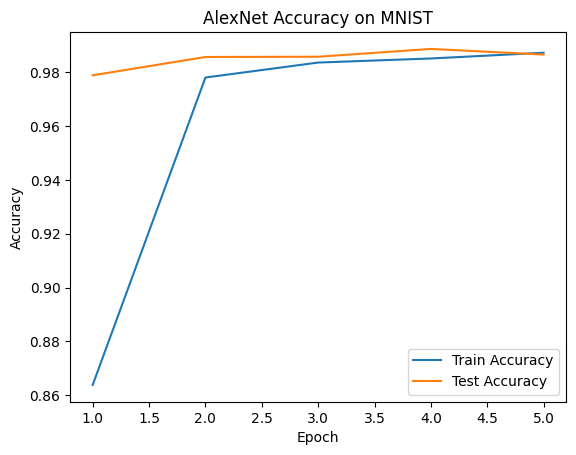

In [31]:
# Plot Training and Test Accuracy
# Purpose: Visualize how accuracy improves over epochs for training and test datasets.
plt.figure()
# Q: Why create a new figure for plotting?
# A: A new figure ensures a clean canvas for the accuracy plot, avoiding overlap with other plots.
plt.plot(range(1, epochs+1), train_accuracies, label="Train Accuracy")
# Q: What does this line plot?
# A: This plots training accuracy for each epoch, showing how well the model learns the training data.
plt.plot(range(1, epochs+1), test_accuracies, label="Test Accuracy")
# Q: Why plot test accuracy?
# A: Plotting test accuracy shows how well the model generalizes to unseen data over epochs.
plt.xlabel("Epoch")
# Q: Why label the x-axis?
# A: Labeling the x-axis as “Epoch” indicates the training iteration number for clarity.
plt.ylabel("Accuracy")
# Q: Why label the y-axis?
# A: Labeling the y-axis as “Accuracy” shows the metric being plotted (fraction of correct predictions).
plt.title("AlexNet Accuracy on MNIST")
# Q: Why set a title for the plot?
# A: The title identifies the plot’s purpose, showing it’s for AlexNet’s accuracy on MNIST.
plt.legend()  # Q: What does the legend show?
# A: The legend distinguishes between training and test accuracy lines for easy interpretation.
plt.savefig("accuracy.png")
# Q: Why save the plot to a file?
# A: Saving the plot allows you to keep a record or share the visualization later.
plt.show()
# Q: Why display the plot?
# A: Displaying the plot lets you visually analyze the model’s performance immediately.

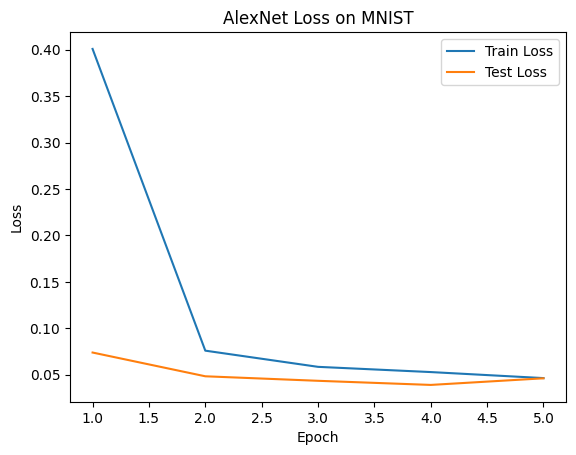

In [32]:
# Plot Training and Test Loss
# Purpose: Visualize how loss decreases over epochs for training and test datasets.
plt.figure()
# Q: Why create another figure?
# A: A new figure ensures a clean canvas for the loss plot, avoiding overlap with the accuracy plot.
plt.plot(range(1, epochs+1), train_losses, label="Train Loss")
# Q: What does this line plot?
# A: This plots training loss for each epoch, showing how the model’s error decreases.
plt.plot(range(1, epochs+1), test_losses, label="Test Loss")
# Q: Why plot test loss?
# A: Plotting test loss shows how the model’s error on unseen data changes, indicating generalization.
plt.xlabel("Epoch")
# Q: Why label the x-axis again?
# A: Labeling the x-axis as “Epoch” clarifies the training iteration for the loss plot.
plt.ylabel("Loss")
# Q: Why label the y-axis as Loss?
# A: Labeling the y-axis as “Loss” indicates the metric being plotted (prediction error).
plt.title("AlexNet Loss on MNIST")
# Q: Why set a title for this plot?
# A: The title specifies that the plot shows AlexNet’s loss on MNIST, for clarity.
plt.legend()
# Q: Why include a legend here?
# A: The legend distinguishes between training and test loss lines for easy interpretation.
plt.savefig("loss.png")
# Q: Why save this plot?
# A: Saving the plot preserves the loss visualization for later reference or sharing.
plt.show()
# Q: Why display this plot?
# A: Displaying the plot allows immediate visual analysis of the model’s error trends.

In [ ]:
# Save Model
# Purpose: Store the trained model weights for future use.
torch.save(model.state_dict(), "alexnet_weights.pth")
# Q: Why save the model weights?
# A: Saving weights allows reloading the trained model for inference or further training.

In [33]:
# Prediction on New Data (Example)
# Purpose: Demonstrate how to use the trained model to predict on a single new image.
# Note: This is an example to show prediction; actual new data would require loading a specific image.
model.eval()  # Set model to evaluation mode for prediction
with torch.no_grad():  # Disable gradients for prediction to save memory
    sample_image, sample_label = next(iter(test_loader))  # Get one batch from test_loader
    sample_image = sample_image[0:1].to(device)  # Take one image and move to device
    # Forward Propagation for Prediction
    # Purpose: Pass a single image through the model to predict its class.
    output = model(sample_image)  # Compute prediction scores
    _, predicted = torch.max(output, 1)  # Get predicted class
    print(f"Predicted class for sample image: {predicted.item()}")  # Display prediction

Predicted class for sample image: 7


In [35]:
sample_image

tensor([[[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          ...,
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]]]],
       device='cuda:0')

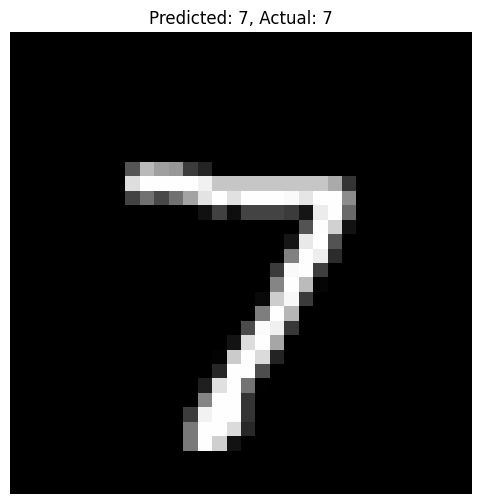

Predicted class: 7


In [40]:
# Prediction on New Data with Image Display
model.eval()
with torch.no_grad():
    sample_image, sample_label = next(iter(test_loader))
    sample_image = sample_image[0:1].to(device)

    # Prediction
    output = model(sample_image)
    _, predicted = torch.max(output, 1)

    # Display image
    img_show = sample_image.cpu().squeeze(0)
    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())

    plt.figure(figsize=(6, 6))
    if img_show.shape[0] == 1:  # Grayscale
        plt.imshow(img_show.squeeze(), cmap='gray')
    else:  # RGB
        plt.imshow(img_show.permute(1, 2, 0))

    plt.title(f'Predicted: {predicted.item()}, Actual: {sample_label[0].item()}')
    plt.axis('off')
    plt.show()

    print(f"Predicted class: {predicted.item()}")
